In [2]:
%load_ext autoreload

%autoreload 2
import video_processing as vp
import librain as lb
import fnames
import animation
import numpy as np
from roipoly import RoiPoly 
import matplotlib.pyplot as plt

import warnings
import imreg_dft as ird
warnings.filterwarnings('ignore')


## Constants

In [3]:
WIDTH = 256
HEIGHT = 256
TRUE_FRAMERATE = 28.815
BEHAVIOUR_FRAMERATE = 30# 1/(11090.9/1e6)
ephys_fs = 25000

## File paths

In [34]:
path = "B:/Dual/" # location of "date" folders

direc = lb.Data(path)

date = "20190815"

experiment = "Experiment_2"

# help(direc.experiment)

EXP_3 = direc.experiment(date, exp_num=1)

# help(direc.file)

l_mouse = direc.file(exp_folder=EXP_3, fname="left")

# try: print(fnames.fnames.get("left")) to see an example of a file that would correspond to fname="left" in direc.file

r_mouse = direc.file(exp_folder=EXP_3, fname="right")

l_mouse_timestamps_raw = direc.file(
    exp_folder=EXP_3, fname="left timestamps"
)

r_mouse_timestamps_raw = direc.file(
    exp_folder=EXP_3, fname="right timestamps"
)

res = lb.Output(EXP_3) # root directory where processed files will be saved

filename = direc.file(
    exp_folder=EXP_3, fname="h264", subfolder="Behaviour"
)


In [35]:
print(l_mouse)
print(r_mouse_timestamps_raw)

B:\Dual\20190815\Experiment_1\MM001L-s_M003R-m_August-15_1057_experiment-1_BU.raw
B:\Dual\20190815\Experiment_1\MM003R-m_M001L-s_August-15_1056_experiment-1_BU_timestamps.raw


## Extract the color channels from the RAW files

In [36]:
l_mouse_green_frames = vp.extract_RAW_frames(
    filename=l_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)

r_mouse_green_frames = vp.extract_RAW_frames(
    filename=r_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)

l_mouse_blue_frames = vp.extract_RAW_frames(
    filename=l_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

r_mouse_blue_frames = vp.extract_RAW_frames(
    filename=r_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

# l_mouse_red_frames = vp.extract_RAW_frames(
#     filename=l_mouse,
#     channel='red',
#     width=WIDTH,
#     height=HEIGHT
# )

# r_mouse_red_frames = vp.extract_RAW_frames(
#     filename=r_mouse,
#     channel='red',
#     width=WIDTH,
#     height=HEIGHT
# )

12073.0
12080.0
12073.0
12080.0


### Import RAW timestamps and clean the data

In [37]:
l_mouse_timestamps = vp.clean_raw_timestamps(l_mouse_timestamps_raw)
r_mouse_timestamps = vp.clean_raw_timestamps(r_mouse_timestamps_raw)

In [38]:
print(l_mouse_timestamps.shape), print(r_mouse_timestamps.shape)

l_green_frame = res.saveas(
    f_out=l_mouse_green_frames[1000],
    suffix="LEFT_RAW_GREEN_FRAME",
    path=EXP_3,
    ftype="npy",
    save=True,
)

r_green_frame = res.saveas(
    f_out=r_mouse_green_frames[1000],
    suffix="RIGHT_RAW_GREEN_FRAME",
    path=EXP_3,
    ftype="npy",
    save=True,
)

l_blue_frame = res.saveas(
    f_out=l_mouse_blue_frames[1000],
    suffix="LEFT_RAW_BLUE_FRAME",
    path=EXP_3,
    ftype="npy",
    save=True,
)

r_blue_frame = res.saveas(
    f_out=r_mouse_blue_frames[1000],
    suffix="RIGHT_RAW_BLUE_FRAME",
    path=EXP_3,
    ftype="npy",
    save=True,
)

(12073,)
(12080,)
Saved as LEFT_RAW_GREEN_FRAME.npy
Saved as RIGHT_RAW_GREEN_FRAME.npy
Saved as LEFT_RAW_BLUE_FRAME.npy
Saved as RIGHT_RAW_BLUE_FRAME.npy


### Remove dark frames

In [39]:
# slice by threshold on green frames
l_mouse_slice = vp.DarkFramesSlice.threshold_method(l_mouse_green_frames)
r_mouse_slice = vp.DarkFramesSlice.threshold_method(r_mouse_green_frames)

print(l_mouse_green_frames.shape)
# slice green frames
l_mouse_green_frames = l_mouse_green_frames[l_mouse_slice]
r_mouse_green_frames = r_mouse_green_frames[r_mouse_slice]

print(l_mouse_green_frames.shape)

# slice blue frames
l_mouse_blue_frames = l_mouse_blue_frames[l_mouse_slice]
r_mouse_blue_frames = r_mouse_blue_frames[r_mouse_slice]

# slice timestamps
l_mouse_timestamps = l_mouse_timestamps[l_mouse_slice]
r_mouse_timestamps = r_mouse_timestamps[r_mouse_slice]

(12073, 256, 256)
(11896, 256, 256)


In [40]:
l_mouse_green_frames.shape, r_mouse_green_frames.shape

((11896, 256, 256), (11893, 256, 256))

# Register images if movement occurs

In [41]:
# # Left mouse
im0 = l_mouse_green_frames[10,:,:]
for i in range(l_mouse_green_frames.shape[0]):
    im1 = l_mouse_green_frames[i, :, :]
    result = ird.translation(im0, im1)
    tvec = result["tvec"].round(4)
    l_mouse_green_frames[i, :, :] = ird.transform_img(im1, tvec=tvec)


# Right mouse
im0 = r_mouse_green_frames[10,:,:]
for i in range(r_mouse_green_frames.shape[0]):
    im1 = r_mouse_green_frames[i, :, :]
    result = ird.translation(im0, im1)
    tvec = result["tvec"].round(4)
    r_mouse_green_frames[i, :, :] = ird.transform_img(im1, tvec=tvec)



### Find locations of any dropped frames

In [42]:
l_mouse_delta, l_mouse_where_dropped = vp.get_locations_of_dropped_frames(
    timestamps=l_mouse_timestamps,
    threshold=50_000
)

r_mouse_delta, r_mouse_where_dropped = vp.get_locations_of_dropped_frames(
    timestamps=r_mouse_timestamps,
    threshold=50_000
)

l_mouse_green_frames = l_mouse_green_frames.astype('float32')
r_mouse_green_frames = r_mouse_green_frames.astype('float32')

l_mouse_blue_frames = l_mouse_blue_frames.astype('float32')
r_mouse_blue_frames = r_mouse_blue_frames.astype('float32')

Mean filtered frame difference:  34703.918
Mean filtered frame difference:  34704.062


### Fill in dropped frames by interpolating available data

In [43]:
#---------------------------- Green frames, left mouse ---------------------------#

# Create a list of DroppedFrames objects
list_of_dropped_frames_l_green = [
    vp.DroppedFrames(*args) for args in vp.generate_frames(
        l_mouse_green_frames,
        l_mouse_delta,
        l_mouse_where_dropped,
        TRUE_FRAMERATE
    )  
]

# Produce the interpolated frames
list_of_interpolated_dropped_frames_l_green = [
    DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_l_green
]

l_mouse_green_frames = vp.insert_interpolated_frames(
    l_mouse_green_frames,
    list_of_interpolated_dropped_frames_l_green
)

#---------------------------- Blue frames, left mouse ---------------------------#

# Create a list of DroppedFrames objects
list_of_dropped_frames_l_blue = [
    vp.DroppedFrames(*args) for args in vp.generate_frames(
        l_mouse_blue_frames,
        l_mouse_delta,
        l_mouse_where_dropped,
        TRUE_FRAMERATE
    )  
]

# Produce the interpolated frames
list_of_interpolated_dropped_frames_l_blue = [
    DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_l_blue
]

l_mouse_blue_frames = vp.insert_interpolated_frames(
    l_mouse_blue_frames,
    list_of_interpolated_dropped_frames_l_blue
)

#---------------------------- Red frames, left mouse ---------------------------#

# # Create a list of DroppedFrames objects
# list_of_dropped_frames_l_red = [
#     vp.DroppedFrames(*args) for args in vp.generate_frames(
#         l_mouse_red_frames,
#         l_mouse_delta,
#         l_mouse_where_dropped,
#         TRUE_FRAMERATE
#     )  
# ]

# # Produce the interpolated frames
# list_of_interpolated_dropped_frames_l_red = [
#     DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_l_red
# ]

# l_mouse_red_frames = vp.insert_interpolated_frames(
#     l_mouse_red_frames,
#     list_of_interpolated_dropped_frames_l_red
# )

In [44]:
#---------------------------- Green frames, right mouse ----------------------------#

# Create a list of DroppedFrames objects
list_of_dropped_frames_r_green = [
    vp.DroppedFrames(*args) for args in vp.generate_frames(
        r_mouse_green_frames,
        r_mouse_delta,
        r_mouse_where_dropped,
        TRUE_FRAMERATE
    )  
]

# Produce the interpolated frames
list_of_interpolated_dropped_frames_r_green = [
    DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_r_green
]

r_mouse_green_frames = vp.insert_interpolated_frames(
    r_mouse_green_frames,
    list_of_interpolated_dropped_frames_r_green
)

#---------------------------- Blue frames, right mouse ----------------------------#

# Create a list of DroppedFrames objects
list_of_dropped_frames_r_blue = [
    vp.DroppedFrames(*args) for args in vp.generate_frames(
        r_mouse_blue_frames,
        r_mouse_delta,
        r_mouse_where_dropped,
        TRUE_FRAMERATE
    )  
]

# Produce the interpolated frames
list_of_interpolated_dropped_frames_r_blue = [
    DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_r_blue
]

r_mouse_blue_frames = vp.insert_interpolated_frames(
    r_mouse_blue_frames,
    list_of_interpolated_dropped_frames_r_blue
)

#---------------------------- Red frames, right mouse ----------------------------#

# # Create a list of DroppedFrames objects
# list_of_dropped_frames_r_red = [
#     vp.DroppedFrames(*args) for args in vp.generate_frames(
#         r_mouse_red_frames,
#         r_mouse_delta,
#         r_mouse_where_dropped,
#         TRUE_FRAMERATE
#     )  
# ]

# # Produce the interpolated frames
# list_of_interpolated_dropped_frames_r_red = [
#     DroppedFrames.interpolate() for DroppedFrames in list_of_dropped_frames_r_red
# ]

# r_mouse_red_frames = vp.insert_interpolated_frames(
#     r_mouse_red_frames,
#     list_of_interpolated_dropped_frames_r_red
# )

###  Calculate $\frac{\Delta F}{F _{0}}$
#### Where:
####     $F_{0}$ = $\frac{1}{n}\sum_{i=1}^{n} F_{i}$
####     $\Delta F$ = $F - F_{0}$

In [45]:
l_mouse_green_frames, l_mouse_green_variance = vp.calculate_df_f0(l_mouse_green_frames)
l_mouse_blue_frames, l_mouse_blue_variance = vp.calculate_df_f0(l_mouse_blue_frames)
# l_mouse_red_frames, l_mouse_red_variance = vp.calculate_df_f0(l_mouse_red_frames)

r_mouse_green_frames, r_mouse_green_variance = vp.calculate_df_f0(r_mouse_green_frames)
r_mouse_blue_frames, r_mouse_blue_variance = vp.calculate_df_f0(r_mouse_blue_frames)
# r_mouse_red_frames, r_mouse_red_variance = vp.calculate_df_f0(r_mouse_red_frames)

In [46]:
print(np.shape(l_mouse_green_frames))

(11898, 256, 256)


## Apply lfilter using chebychev type 1 filter parameters 

In [ ]:
# initialise the filtering paramters by creating a Filter object
low_limit = 0.01
high_limit = 12.0

filt = vp.Filter(
    low_freq_cutoff=low_limit,
    high_freq_cutoff=high_limit,
    frame_rate=TRUE_FRAMERATE
)

# apply the filters
l_mouse_green_frames = filt.filter(l_mouse_green_frames)
r_mouse_green_frames = filt.filter(r_mouse_green_frames)
l_mouse_blue_frames = filt.filter(l_mouse_blue_frames)
r_mouse_blue_frames = filt.filter(r_mouse_blue_frames)
# l_mouse_red_frames = filt.filter(l_mouse_red_frames)
# r_mouse_red_frames = filt.filter(r_mouse_red_frames)

## Ensure the frames have the same dimensions

In [22]:
if l_mouse_green_frames.shape[0] != r_mouse_green_frames.shape[0]:
    if l_mouse_green_frames.shape[0] < r_mouse_green_frames.shape[0]:
        r_mouse_green_frames = r_mouse_green_frames[:l_mouse_green_frames.shape[0]]
        r_mouse_blue_frames = r_mouse_blue_frames[:l_mouse_blue_frames.shape[0]]
#         r_mouse_red_frames = r_mouse_red_frames[:l_mouse_red_frames_frames.shape[0]]
    elif r_mouse_green_frames.shape[0] < l_mouse_green_frames.shape[0]:
        l_mouse_green_frames = l_mouse_green_frames[:r_mouse_green_frames.shape[0]]
        l_mouse_blue_frames = l_mouse_blue_frames[:r_mouse_blue_frames.shape[0]]
#         l_mouse_red_frames = l_mouse_red_frames[:r_mouse_red_frames.shape[0]]

assert l_mouse_green_frames.shape[0] == r_mouse_green_frames.shape[0]

# Electrophysiology

In [205]:
import scipy.io as sio

ephys_data='B:/Dual/20190729/Experiment_2/sortsleft.mat'
mat_contents = sio.loadmat(ephys_data)
sorted(mat_contents.keys())

final_locs = mat_contents['final_locs']
spike_times = final_locs[0][3]/ephys_fs
print(np.shape(spike_times))

(3335, 1)


409.78136


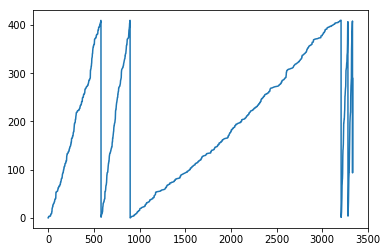

In [206]:
image_times = (l_mouse_timestamps-l_mouse_timestamps[0])/1000000
print(np.max(spike_times))
# print(spike_times)
# print(image_times)
plt.figure()
plt.plot(spike_times)

In [207]:
image_times = np.arange(l_mouse_green_frames.shape[0])/TRUE_FRAMERATE

spike_frame_index = []
count = 0
for i in image_times:
    if any(abs(spike_times-i) < 1/TRUE_FRAMERATE):
        spike_frame_index.append(count)
    count += 1



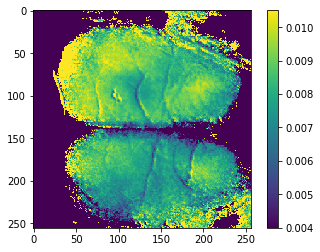

In [208]:
spike_frames = l_mouse_green_frames[spike_frame_index, :, :]
plt.figure()
plt.imshow(np.mean(spike_frames, axis=0), vmin = 0.004, vmax = 0.0105)
plt.colorbar()

## Save processed frames 

In [23]:


# help(res.saveas)

l_mouse_green_frames_fname = res.saveas(
    f_out=l_mouse_green_frames,
    prefix="LEFT_GREEN_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    ftype="raw",
    dtype="float32",
    f_in=l_mouse,
    save=True
)

l_mouse_blue_frames_fname = res.saveas(
    f_out=l_mouse_blue_frames,
    prefix="LEFT_BLUE_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    ftype="raw",
    dtype="float32",
    f_in=l_mouse,
    save=True,
)

# l_mouse_red_frames_fname = res.saveas(
#     f_out=l_mouse_red_frames,
#     prefix="LEFT_RED_processed_dff0_bandpass{}-{}Hz".format(
#         low_limit, high_limit
#     ),
#     ftype="raw",
#     dtype="float32",
#     f_in=l_mouse,
#     save=True,
# )

r_mouse_green_frames_fname = res.saveas(
    f_out=r_mouse_green_frames,
    prefix="RIGHT_GREEN_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    ftype="raw",
    dtype="float32",
    f_in=r_mouse,
    save=True,
)

r_mouse_blue_frames_fname = res.saveas(
    f_out=r_mouse_blue_frames,
    prefix="RIGHT_BLUE_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    ftype="raw",
    dtype="float32",
    f_in=r_mouse,
    save=True,
)

# r_mouse_red_frames_fname = res.saveas(
#     f_out=r_mouse_red_frames,
#     prefix="RIGHT_RED_processed_dff0_bandpass{}-{}Hz".format(
#         low_limit, high_limit
#     ),
#     ftype="raw",
#     dtype="float32",
#     f_in=r_mouse,
#     save=True,
# )

Saved as LEFT_GREEN_processed_dff0_bandpass0.01-12.0Hz_MM001L-s_M002R-m_August-16_1206_experiment-1_BU.raw
Saved as LEFT_BLUE_processed_dff0_bandpass0.01-12.0Hz_MM001L-s_M002R-m_August-16_1206_experiment-1_BU.raw
Saved as RIGHT_GREEN_processed_dff0_bandpass0.01-12.0Hz_MM002R-m_M001L-s_August-16_1206_experiment-1_BU.raw
Saved as RIGHT_BLUE_processed_dff0_bandpass0.01-12.0Hz_MM002R-m_M001L-s_August-16_1206_experiment-1_BU.raw


## Perform signal correction $\frac{A}{B+1}$

### Where:
### A = $\frac{\Delta F}{F _{0}}$ from fluorescence
### B = $\frac{\Delta F}{F _{0}}$ from reflectance

In [24]:
l_mouse_green_by_blue = vp.correct_channel_a_by_b(
    l_mouse_green_frames,
    l_mouse_blue_frames
)
# l_mouse_green_by_red = vp.correct_channel_a_by_b(
#     l_mouse_green,
#     l_mouse_red
# )
r_mouse_green_by_blue = vp.correct_channel_a_by_b(
    r_mouse_green_frames,
    r_mouse_blue_frames
)
# r_mouse_green_by_red = vp.correct_channel_a_by_b(
#     r_mouse_green,
#     r_mouse_red
# )

## Save corrected frames

In [25]:
l_green_by_blue = res.saveas(
    f_out=l_mouse_green_by_blue,
    prefix="LEFT_corrected_g_by_b_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    dtype='float32',
    ftype="raw",
    f_in=l_mouse,
    save=True,
)

# l_green_by_red = res.saveas(
#     f_out=l_mouse_green_by_red,
#     prefix="LEFT_corrected_g_by_r_processed_dff0_bandpass{}-{}Hz".format(
#         low_limit, high_limit
#     ),
#     ftype="raw",
#     f_in=l_mouse,
#     save=True,
# )

r_green_by_blue = res.saveas(
    f_out=r_mouse_green_by_blue,
    prefix="RIGHT_corrected_g_by_b_processed_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    dtype='float32',
    ftype="raw",
    f_in=r_mouse,
    save=True,
)

# r_green_by_red = res.saveas(
#     f_out=r_mouse_green_by_red,
#     prefix="RIGHT_corrected_g_by_r_processed_dff0_bandpass{}-{}Hz".format(
#         low_limit, high_limit
#     ),
#     ftype="raw",
#     f_in=r_mouse,
#     save=True,
# )

Saved as LEFT_corrected_g_by_b_processed_dff0_bandpass0.01-12.0Hz_MM001L-s_M002R-m_August-16_1206_experiment-1_BU.raw
Saved as RIGHT_corrected_g_by_b_processed_dff0_bandpass0.01-12.0Hz_MM002R-m_M001L-s_August-16_1206_experiment-1_BU.raw


### Save Animation of these frames

In [37]:
left = {
    'Left Mouse Red': l_mouse_red,
    'Left Mouse Green': l_mouse_green,
    'Left Mouse Blue': l_mouse_blue,
    'Left Mouse $\frac{Green}{Blue}$': l_mouse_green_by_blue,
    'Left Mouse S\frac{Green}{Red}S': l_mouse_green_by_red,
}
right = {
    'Right Mouse Red': r_mouse_red,
    'Right Mouse Green': r_mouse_green,
    'Right Mouse Blue': r_mouse_blue,
    'Right Mouse $\frac{Green}{Blue}$': r_mouse_green_by_blue,
    'Right Mouse S\frac{Green}{Red}S': r_mouse_green_by_red,
}
metadata = {
    'title' : 'This is the title !!!', 
    'artist': 'Fed',
    'comment' : '10Hz_playback'
}

NameError: name 'l_mouse_red' is not defined

In [ ]:
animation.animate_processed_frames(
    left, 
    right, 
    metadata=metadata, 
    filename="some_file.mp4", 
    true_framerate=TRUE_FRAMERATE)

## Behaviour video frames

In [27]:
behavior_frames = vp.load_frames(
    filename,
    color='red'
)

behavior_frames_fname = res.saveas(
    path=EXP_3 + "\\" + "Behaviour",
    f_out=behavior_frames,
    suffix="test",
    ftype="raw",
    dtype='uint8',
    save=True
)

Saved as test.raw


### Draw a Region of Interest. 

From the [github](https://github.com/jdoepfert/roipoly.py) documentation, we have:

Creating a ROI

In your python code, import the roipoly module using
```python
from roipoly import RoiPoly
```
To draw a ROI within an image present as a numpy array, show it first using e.g. pylabs’s imshow:
```python
from matplotlib import pyplot as plt
plt.imshow(image)
```
Then let the user draw a polygonal ROI within that image:
```python
my_roi = RoiPoly(color='r') # draw new ROI in red color
```
This lets the user interactively draw a polygon within the image by clicking with the left mouse button to select the vertices of the polygon. To close the polygon, click with the right mouse button. After finishing the ROI, the current figure is closed so that the execution of the code can continue.

We achieve this in the notebook by switching to the qt console then back to inline using jupyter magic:

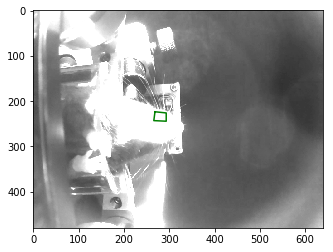

In [28]:
%matplotlib qt
plt.figure()
plt.imshow(behavior_frames[1000], cmap='gray', vmin=0, vmax=255)
roi = RoiPoly(color='g')

# Let's see what we have
%matplotlib inline
plt.imshow(behavior_frames[1000], cmap='gray', vmin=0, vmax=255)
roi.display_roi()

### Remove Dark frames where lights go on/off

(12606, 480, 640)


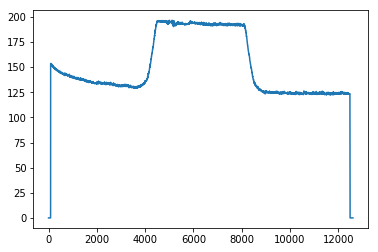

In [29]:
print(behavior_frames.shape)
plt.figure()
plt.plot(np.mean(np.mean(behavior_frames,axis=1),axis=1))

In [30]:
behavior_frames_slice = vp.DarkFramesSlice.threshold_method(
    frames=behavior_frames, 
    threshold=5
)

behavior_frames = behavior_frames[behavior_frames_slice]


In [25]:
# filename='B:/Dual/20190724/Experiment_1/Behaviour/M004L-s_M001R-m_July-24_1804_experiment-1_DK.h264'
# behavior_frames = vp.load_frames(
#     filename,
#     color='red'
# )

print(behavior_frames.shape)

(12396, 480, 640)


### Suppose video A has a higher frame rate than video B.
#### Then we want to extract a subset of frames from A such that the remaining frames temporally correspond closest to the frames in B

In [31]:
behavior_imaging_period, behavior_imaging_frames = 1/BEHAVIOUR_FRAMERATE, np.shape(behavior_frames)[0]
brain_imaging_period, brain_imaging_frames = 1/TRUE_FRAMERATE, np.shape(l_mouse_green_frames)[0]

behavior_imaging_indices, brain_imaging_indices = vp.video_synchronisation_indices(
    behavior_imaging_period,
    behavior_imaging_frames,
    brain_imaging_period,
    brain_imaging_frames
)

behavior_frames = behavior_frames[behavior_imaging_indices]
l_mouse_green_frames = l_mouse_green_frames[brain_imaging_indices]
r_mouse_green_frames = r_mouse_green_frames[brain_imaging_indices]

In [32]:
behavior_frames_fname = res.saveas(
    path=EXP_3,
    f_out=behavior_frames,
    f_in=filename,
    dirname="Behaviour",
    suffix="interpolated",
    ftype="raw",
    dtype="uint8",
    save=True
)

Saved as M001L-s_M002R-m_August-16_1201_experiment-1_BU_interpolated.raw


## Save video of brain activity plus behavior

Writing frames...
Done!


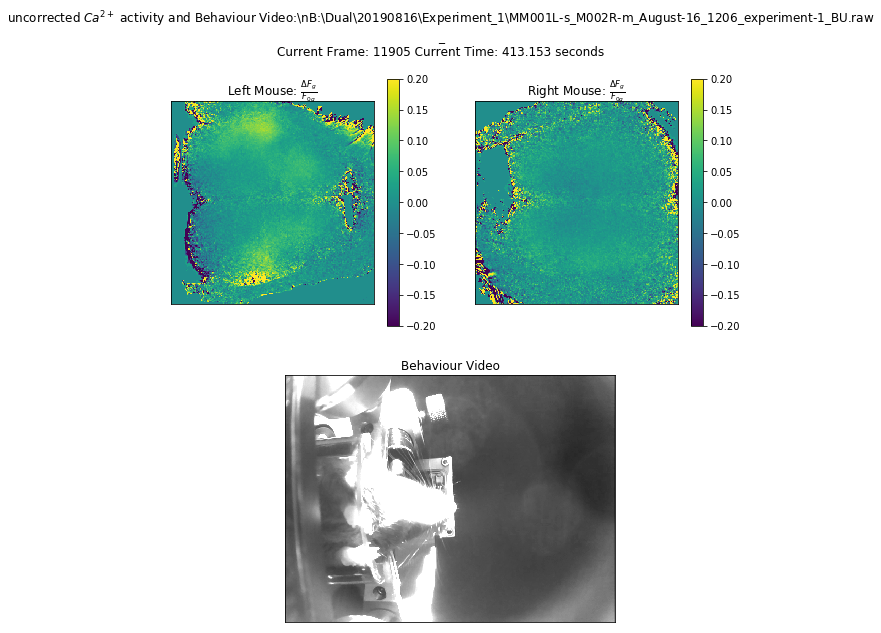

In [33]:
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']


# Generate file name for video; create placeholder array - f_out cannot be empty 
activity_behaviour = res.saveas(
    f_out=np.array(["placeholder"]),
    suffix="activity_and_behaviour_dff0_bandpass{}-{}Hz".format(
        low_limit, high_limit
    ),
    ftype="mp4",
    f_in=l_mouse,
)

metadata = dict(
    title=EXP_3, artist="Fed", comment="10Hz_playback"
)
writer = FFMpegWriter(fps=30, metadata=metadata, bitrate=6000)
fig = plt.figure(figsize=(10, 10))
fig.suptitle("The Signals for:\n"+l_mouse+"\n"+"_"+"\n")

lax1 = fig.add_subplot(2, 2, 1)
#lax1.set_title(r"Left Mouse: $\frac{\Delta F_g/F_{0g}}{1+\Delta F_b/F_{0b}}$")
lax1.set_title(r"Left Mouse: $\frac{\Delta F_g}{F_{0g}}$")
lax1.get_yaxis().set_visible(False)
lax1.get_xaxis().set_visible(False)
lim_gb = lax1.imshow(l_mouse_green_by_blue[0], cmap='viridis', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(lim_gb)

rax1 = fig.add_subplot(2, 2, 2)
#rax1.set_title(r"Right Mouse: $\frac{\Delta F_g/F_{0g}}{1+\Delta F_b/F_{0b}}$")
rax1.set_title(r"Right Mouse: $\frac{\Delta F_g}{F_{0g}}$")
rax1.get_yaxis().set_visible(False)
rax1.get_xaxis().set_visible(False)
rim_gb = rax1.imshow(r_mouse_green_by_blue[0], cmap='viridis', vmin=-0.2, vmax=0.2)
cbar2 = fig.colorbar(rim_gb)

ax3 = fig.add_subplot(2, 1, 2)
ax3.set_title("Behaviour Video")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
im_beh = ax3.imshow(behavior_frames[0], cmap='gray', vmin=0, vmax=255)

#!!!
print("Writing frames...")
with writer.saving(
    fig, outfile=EXP_3 + "\\" + activity_behaviour, dpi=100
):
    for i in range(l_mouse_green_frames.shape[0]):
        # Set title
        current_time = np.round(float(i)/TRUE_FRAMERATE, 3)
        fig.suptitle(r"uncorrected $Ca^{2+}$ activity and Behaviour Video:\n"\
                     +l_mouse+"\n"+\
                    "_"+"\n"+\
                     "Current Frame: "+"{:5d}".format(i)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
        

        lim_gb.set_data(l_mouse_green_frames[i])
        
        rim_gb.set_data(r_mouse_green_frames[i])
        
        im_beh.set_data(behavior_frames[i])

        writer.grab_frame()

print("Done!")

## Stim Averaging